# Check fresh snow density parameterization within CLASSIC

atmosphericVarsCalc.f90 ([code](https://gitlab.com/cccma/classic/-/blob/master/src/atmosphericVarsCalc.f90?ref_type=heads#L127) / [documentation](https://cccma.gitlab.io/classic/atmosphericVarsCalc_8f90.html))

Compares with parameterization tested in SVS2-CROCUS, e.g., https://egusphere.copernicus.org/preprints/2024/egusphere-2024-1237/egusphere-2024-1237.pdf

Wind Effect comprises three modifications within the falling snow density and snowdrift schemes. Following Royer et al. ([2021](https://www.frontiersin.org/articles/10.3389/feart.2021.685140/full)) and Lackner et al. ([2022](https://tc.copernicus.org/articles/16/3357/2022/)), we modified the default parameterisation of Vionnet et al. ([2012](https://gmd.copernicus.org/articles/5/773/2012/)) (Equation 1) that computes falling snow density as a function of wind speed, $U$, and air temperature, $T_a$, as:

$$ \rho_{\text {new }}=\max \left(50, a_p+b_p\left(T_a-T_{\text {fus }}\right)+c_p U^{1 / 2}\right),  $$

where $T_{\text {fus }}$ is the temperature of the melting point for water, $a_p = 109$ kg m$^{-3}$, $b_p = 6$ kg m$^{-3}$ K$^{-1}$ and $c_p = 26$ kg m$^{-7/2}$ s$^{1/2}$. Royer et al. ([2021](https://www.frontiersin.org/articles/10.3389/feart.2021.685140/full)) increased the wind speed parameter $c_p$ by a factor of 2 and found a reduction in the RMSE of surface layer density from 86.5 % to 63.4 % when applied at four Arctic reference sites (TVC, Cambridge Bay, Bylot Island and Samoylov). Motivated by this work, Lackner et al. ([2022](https://tc.copernicus.org/articles/16/3357/2022/)) doubled the density parameter $a_p$ and multiplied $c_p$ by 5 at their reference site of Umiujaq, Canada. These modifications reduced the error in simulated surface density from 127 kg m$^{-3}$
to 38 kg m$^{-3}$. Attempts to apply the modification proposed by Lackner et al. ([2022](https://tc.copernicus.org/articles/16/3357/2022/)) to TVC within this study found the increased parameters produced
unrealistic densities throughout the entire snowpack (> 800 kg m$^{-3}$). We therefore chose to implement the parameters proposed
by Royer et al. ([2021](https://www.frontiersin.org/articles/10.3389/feart.2021.685140/full)) (R21) and two further parameter values of $c_p = 39$ kg m$^{-7/2}$ s$^{1/2}$ and $c_p = 32.5$ kg m$^{-7/2}$ s$^{1/2}$ (described as GW1 and GW2 in Fig. 1) to account for the uncertainties associated with the impact of wind speed on snowfall density (Walter et al., [2023](https://tc.copernicus.org/preprints/tc-2023-112/)).

Surface snow densities range from 70-100 kg m$^{-3}$ for Alpine fresh snow deposited under weak wind conditions, up to typically 200-300 kg m$^{-3}$ for strongly wind affected surface snow in Arctic and Antarctic regions (Brun et al., [1997](https://www.cambridge.org/core/journals/annals-of-glaciology/article/coupling-a-multilayered-snow-model-with-a-gcm/6CF67C314B5A8743FA0CF33B8BD89CA7)).

<mark>Voir les params décrites dans Walter également (SNOWPACK and SnowModel)</mark>

In [1]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import os

## Bylot Island, Canadian high Arctic

The site is a low-center polygon, with herb tundra and no erect vegetation

| Short name | byl |
|:-----------|:----|
| Location | 73.1504ºN, 80.0046ºW |
| Elevation | 25 m |
| Snow-free albedo | - |
| Simulation period | 11 July 2013 to 25 June 2019 |
| Temperature/humidity measurement height | 2.3 m |
| Wind measurement height | 2.3 m |
| Reference | Domine et al. ([2021](https://essd.copernicus.org/articles/13/4331/2021/)) |

In [2]:
site = 'byl'
site_longname = 'Bylot Island, Canadian high Arctic'

year_start = '2013'
year_end = '2019'

lat = 73.1504
lon = -80.0046

path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/'+site+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/byl already exist.
/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/byl/forcing already exist.


### Open original forcing file

In [83]:
ds = xr.open_dataset(path+'/met_insitu_'+site+'_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 52202)
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...
Data variables:
    Wind     (time) float64 418kB ...
    Tair     (time) float64 418kB ...
    Qair     (time) float64 418kB ...
    LWdown   (time) float64 418kB ...
    SWdown   (time) float64 418kB ...
    Psurf    (time) float64 418kB ...
    Rainf    (time) float64 418kB ...
    Snowf    (time) float64 418kB ...

### Compute fresh snow density

https://cccma.gitlab.io/classic/atmosphericVarsCalc_8f90.html

```
if (TA(I) <= TFREZ) then
      RHOSNI(I) = 67.92 + 51.25 * EXP((TA(I) - TFREZ) / 2.59) 
    else
      RHOSNI(I) = MIN((119.17 + 20.0 * (TA(I) - TFREZ)),200.0)
    end if
```


In [4]:
ds.Tair.values

array([ 6.8199535 ,  6.95764435,  8.92526895, ..., 10.744     ,
       10.433     ,  9.186     ])

In [49]:
# T in °C
def compute_rho_new_CLASSIC(ds_tas):
    # Tair < 0°C
    rho_new_neg = 67.92 + 51.25 * np.exp(ds_tas.where(ds_tas < 0) / 2.59)

    # Tair >= 0°C
    temp = 119.17 + 20.0 * ds_tas.where(ds_tas >= 0)
    rho_new_pos = temp.where(temp < 200, other=200).where(ds.Tair >= 0)

    # Combine
    rho_new = rho_new_neg.fillna(rho_new_pos)
    
    return rho_new

In [50]:
rho_new_CLASSIC = compute_rho_new_CLASSIC(ds.Tair)
rho_new_CLASSIC

<xarray.DataArray 'Tair' (time: 52202)> Size: 418kB
array([200., 200., 200., ..., 200., 200., 200.])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [35]:
# T in °C
def compute_rho_new_CROCUS(ds_tas, ds_wind):
    a = 109 # kg/m3
    b = 6 # kg/m3/K
    c = 26 # kg/m7/2*s1/2
    
    rho = a + b*ds_tas + c*ds_wind**(1/2)
    rho_new = rho.where(rho > 50, other=50) 
    
    return rho_new

In [36]:
rho_new_CROCUS = compute_rho_new_CROCUS(ds.Tair, ds.Wind)
rho_new_CROCUS

<xarray.DataArray (time: 52202)> Size: 418kB
array([182.07994488, 181.56436704, 199.51370239, ..., 210.82628044,
       202.9061459 , 191.81545848])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [62]:
# T in °C
def compute_rho_new_CROCUS_Arctic_R21(ds_tas, ds_wind):
    a = 109 # kg/m3
    b = 6 # kg/m3/K
    c = 26*2 # kg/m7/2*s1/2
    
    rho = a + b*ds_tas + c*ds_wind**(1/2)
    rho_new = rho.where(rho > 50, other=50) 
    
    return rho_new

In [63]:
rho_new_CROCUS_Arctic_R21 = compute_rho_new_CROCUS_Arctic_R21(ds.Tair, ds.Wind)
rho_new_CROCUS_Arctic_R21

<xarray.DataArray (time: 52202)> Size: 418kB
array([214.24016876, 212.38286797, 236.47579107, ..., 248.18856089,
       234.21429181, 219.51491696])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [65]:
# T in °C
def compute_rho_new_CROCUS_Arctic_L22(ds_tas, ds_wind):
    a = 109*2 # kg/m3
    b = 6 # kg/m3/K
    c = 26*5 # kg/m7/2*s1/2
    
    rho = a + b*ds_tas + c*ds_wind**(1/2)
    rho_new = rho.where(rho > 50, other=50) 
    
    return rho_new

In [66]:
rho_new_CROCUS_Arctic_L22 = compute_rho_new_CROCUS_Arctic_L22(ds.Tair, ds.Wind)
rho_new_CROCUS_Arctic_L22

<xarray.DataArray (time: 52202)> Size: 418kB
array([419.7208404 , 413.83837078, 456.36205713, ..., 469.27540222,
       437.13872952, 411.61329239])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [153]:
# T in °C
def compute_rho_new_CROCUS_Arctic_GW1(ds_tas, ds_wind):
    a = 109 # kg/m3
    b = 6 # kg/m3/K
    c = 39 # kg/m7/2*s1/2
    
    rho = a + b*ds_tas + c*ds_wind**(1/2)
    rho_new = rho.where(rho > 50, other=50) 
    
    return rho_new

In [154]:
rho_new_CROCUS_Arctic_GW1 = compute_rho_new_CROCUS_Arctic_GW1(ds.Tair, ds.Wind)
rho_new_CROCUS_Arctic_GW1

<xarray.DataArray (time: 52202)> Size: 418kB
array([198.16005682, 196.97361751, 217.99474673, ..., 229.50742067,
       218.56021886, 205.66518772])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [155]:
# T in °C
def compute_rho_new_CROCUS_Arctic_GW2(ds_tas, ds_wind):
    a = 109 # kg/m3
    b = 6 # kg/m3/K
    c = 32.5 # kg/m7/2*s1/2
    
    rho = a + b*ds_tas + c*ds_wind**(1/2)
    rho_new = rho.where(rho > 50, other=50) 
    
    return rho_new

In [156]:
rho_new_CROCUS_Arctic_GW2 = compute_rho_new_CROCUS_Arctic_GW2(ds.Tair, ds.Wind)
rho_new_CROCUS_Arctic_GW2

<xarray.DataArray (time: 52202)> Size: 418kB
array([190.12000085, 189.26899227, 208.75422456, ..., 220.16685056,
       210.73318238, 198.7403231 ])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [159]:
# T in °C
def compute_rho_new_CROCUS_Arctic_W24(ds_tas, ds_wind):
    a = 43 # kg/m3
    b = 9 # kg/m3/K
    c = 35 # kg/m7/2*s1/2
    
    rho = a + b*ds_tas + c*ds_wind**(1/2)
    rho_new = rho.where(rho > 50, other=50) 
    
    return rho_new

In [160]:
rho_new_CROCUS_Arctic_W24 = compute_rho_new_CROCUS_Arctic_W24(ds.Tair, ds.Wind)
rho_new_CROCUS_Arctic_W24

<xarray.DataArray (time: 52202)> Size: 418kB
array([147.67219057, 147.10524272, 173.0840784 , ..., 189.99137752,
       179.04258103, 162.96173257])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [84]:
df = pd.read_csv(path+'/Bylot_driving_dataV2.csv', parse_dates=['DATE'], dayfirst=True, index_col=['DATE'])
ds_orig = df.to_xarray()
df

,WindSpeed m/s,0=Data; 1=Gap-filled,Air Temp. °C,Relative Humidity,Specific humidity g/kg,Long Wave Downwell. CNR4 W m-2,0=CNR4; 1=Modified ERA,Long Wave Downwell. ERA5 W m-2,Short Wave downwell. CNR4 W m-2,0=CNR4; 1=Modified ERA,Short Wave downwell. ERA5 W m-2,Pressure kPa,Precip. Total mm/h,Precip. Rain,Precip. Snow,Precip season cumul
DATE,,,,,,,,,,,,,,,,
2013-07-11 09:00:00,1.530,0,6.819953,91.18,5.6257,308.859,0,298.371,250.90,0,354.711,100.188543,0.0,0.0,0.0,0.000000
2013-07-11 10:00:00,1.405,0,6.957644,89.27,5.5593,299.669,0,289.269,310.49,0,419.291,100.198543,0.0,0.0,0.0,0.000000
2013-07-11 11:00:00,2.021,0,8.925269,90.20,6.4263,289.596,0,278.748,672.70,0,490.762,100.198543,0.0,0.0,0.0,0.000000
2013-07-11 12:00:00,2.559,0,10.422386,89.57,7.0594,280.483,0,267.848,370.67,0,569.034,100.198543,0.0,0.0,0.0,0.000000
2013-07-11 13:00:00,2.749,0,8.218802,88.42,6.0033,283.789,0,257.987,372.92,0,589.216,100.198543,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-25 06:00:00,0.713,0,11.119000,63.97,5.2158,245.120,0,206.344,343.93,0,359.763,101.345000,0.0,0.0,0.0,20.503224
2019-06-25 07:00:00,0.908,0,10.895000,64.35,5.1667,259.830,0,207.897,419.45,0,436.212,101.390000,0.0,0.0,0.0,20.503224
2019-06-25 08:00:00,2.065,0,10.744000,62.69,4.9798,251.450,0,210.618,516.75,0,514.440,101.440000,0.0,0.0,0.0,20.503224


In [89]:
ds_orig = ds_orig.rename({'DATE': 'time', 'Relative Humidity': 'RH'})
ds_orig

<xarray.Dataset> Size: 7MB
Dimensions:                          (time: 52202)
Coordinates:
  * time                             (time) datetime64[ns] 418kB 2013-07-11T0...
Data variables: (12/16)
    WindSpeed m/s                    (time) float64 418kB 1.53 1.405 ... 1.135
    0=Data; 1=Gap-filled             (time) int64 418kB 0 0 0 0 0 ... 0 0 0 0 0
    Air Temp. °C                     (time) float64 418kB 6.82 6.958 ... 9.186
    RH                               (time) float64 418kB 91.18 89.27 ... 61.9
    Specific humidity g/kg           (time) float64 418kB 5.626 5.559 ... 4.424
    Long Wave Downwell. CNR4 W m-2   (time) float64 418kB 308.9 299.7 ... 257.9
    ...                               ...
    Short Wave downwell. ERA5 W m-2  (time) float64 418kB 354.7 419.3 ... 617.5
    Pressure kPa                     (time) float64 418kB 100.2 100.2 ... 101.5
    Precip. Total  mm/h              (time) float64 418kB 0.0 0.0 ... 0.0 0.0
    Precip. Rain                     (time) float64 418kB 0.0 0.0 ... 0.0 0.0
    Precip. Snow                     (time) float64 418kB 0.0 0.0 ... 0.0 0.0
    Precip  season cumul             (time) float64 418kB 0.0 0.0 ... 20.5 20.5

In [96]:
ds = ds.assign(RH=ds_orig.RH)
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 52202)
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...
Data variables:
    Wind     (time) float64 418kB ...
    Tair     (time) float64 418kB ...
    Qair     (time) float64 418kB ...
    LWdown   (time) float64 418kB ...
    SWdown   (time) float64 418kB ...
    Psurf    (time) float64 418kB ...
    Rainf    (time) float64 418kB ...
    Snowf    (time) float64 418kB ...
    RH       (time) float64 418kB 91.18 89.27 90.2 89.57 ... 62.69 63.68 61.9

In [137]:
# T in °C
def compute_rho_new_SNOWPACK(ds_tas, ds_wind, ds_RH):
    b0 = 3.28
    b1 = 0.03
    b2 = -0.75
    b3 = 0.3
    
    rho_new = 10**(b0 + b1*ds_tas + b2*np.arcsin(np.sqrt(ds_RH/100)) + b3*np.log10(ds_wind))
    
    return rho_new

In [138]:
rho_new_SNOWPACK = compute_rho_new_SNOWPACK(ds.Tair, ds.Wind, ds.RH)
rho_new_SNOWPACK

/home/lalandmi/miniconda3/envs/sc2_v0/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in arcsin
  result_data = func(*input_data)
/home/lalandmi/miniconda3/envs/sc2_v0/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


<xarray.DataArray (time: 52202)> Size: 418kB
array([ 387.31016854,  402.93067005,  501.34005389, ..., 1026.88028199,
        888.0278369 ,  781.4754261 ])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [139]:
# T in °C
def compute_rho_new_SNOWPACK_tunned(ds_tas, ds_wind, ds_RH):
    b0 = 2.16
    b1 = 0.034
    b2 = -0.63
    b3 = 0.97
    
    rho_new = 10**(b0 + b1*ds_tas + b2*np.arcsin(np.sqrt(ds_RH/100)) + b3*np.log10(ds_wind))
    
    return rho_new

In [140]:
rho_new_SNOWPACK_tunned = compute_rho_new_SNOWPACK_tunned(ds.Tair, ds.Wind, ds.RH)
rho_new_SNOWPACK_tunned

<xarray.DataArray (time: 52202)> Size: 418kB
array([ 59.07361027,  57.60396064,  93.50830801, ..., 179.94361644,
       122.78659401,  90.19297294])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [126]:
# T in °C
def compute_rho_new_SnowTran(ds_tas, ds_wind, ds_RH):
    D1 = 25
    D2 = 250
    D3 = 0.2

    ds_tas_K = ds_tas + 273.15
    Tw = ds_tas_K * np.arctan(0.151977 * np.sqrt(ds_RH + 8.313659)) \
            + 0.00391838 * np.sqrt(ds_RH**3) * np.arctan(0.023101 * ds_RH) \
            - np.arctan(ds_RH - 1.676331) \
            + np.arctan(ds_tas_K + ds_RH) \
            - 4.686035
    
    rho_w = D1 + D2 * ( 1.0 - np.exp(-D3*(ds_wind - 5.0)) )

    rho_ns = 50 + 1.7 * ((Tw - 258.16).where((Tw - 258.16) >= 0, other=0))**1.5

    rho_new = rho_ns.where(ds_wind < 5, other=(rho_ns+rho_w))
     
    return rho_new

In [127]:
rho_new_SnowTran = compute_rho_new_SnowTran(ds.Tair, ds.Wind, ds.RH)
rho_new_SnowTran

<xarray.DataArray (time: 52202)> Size: 418kB
array([174.69941434, 161.47886013, 189.50783006, ...,  50.        ,
        50.        ,  50.        ])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

In [130]:
# T in °C
def compute_rho_new_SnowTran_tunned(ds_tas, ds_wind, ds_RH):
    D1 = 17
    D2 = 250
    D3 = 0.06

    ds_tas_K = ds_tas + 273.15
    Tw = ds_tas_K * np.arctan(0.151977 * np.sqrt(ds_RH + 8.313659)) \
            + 0.00391838 * np.sqrt(ds_RH**3) * np.arctan(0.023101 * ds_RH) \
            - np.arctan(ds_RH - 1.676331) \
            + np.arctan(ds_tas_K + ds_RH) \
            - 4.686035
    
    rho_w = D1 + D2 * ( 1.0 - np.exp(-D3*(ds_wind - 5.0)) )

    rho_ns = 50 + 1.7 * ((Tw - 258.16).where((Tw - 258.16) >= 0, other=0))**1.5

    rho_new = rho_ns.where(ds_wind < 5, other=(rho_ns+rho_w))
     
    return rho_new

In [131]:
rho_new_SnowTran_tunned = compute_rho_new_SnowTran_tunned(ds.Tair, ds.Wind, ds.RH)
rho_new_SnowTran_tunned

<xarray.DataArray (time: 52202)> Size: 418kB
array([174.69941434, 161.47886013, 189.50783006, ...,  50.        ,
        50.        ,  50.        ])
Coordinates:
  * time     (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-06-25T1...

Text(0.5, 0.98, 'Bylot')

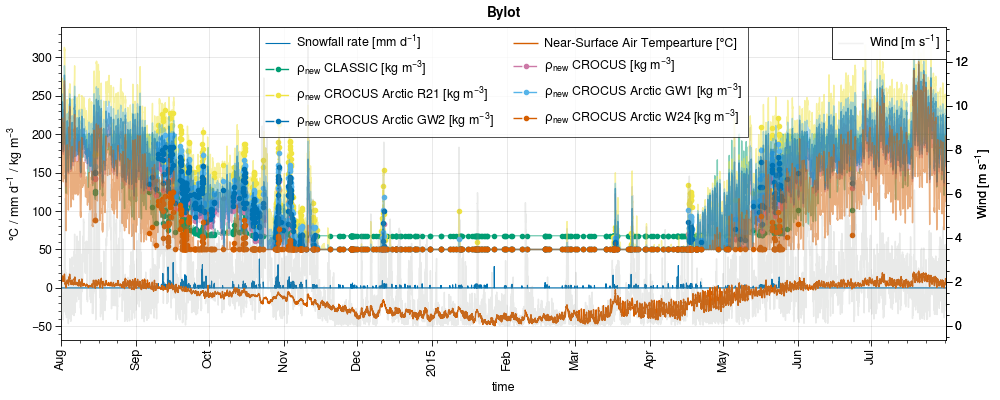

In [161]:
%matplotlib widget

period=slice('2014-08','2015-07')

fig, axs = pplt.subplots(figsize=(10,4))

(ds.sel(time=period).Snowf*86400).plot(label='Snowfall rate [mm d$^{-1}$]', lw=0.8)
ds.sel(time=period).Tair.plot(label='Near-Surface Air Tempearture [°C]', lw=1)

ox = axs[0].alty(label='Wind [m s$^{-1}$]')
ox.plot(ds.sel(time=period).Wind, label='Wind [m s$^{-1}$]', lw=1, c='gray', alpha=0.1)

# CLASSIC
rho_new_CLASSIC.sel(time=period).plot(c='C2', lw=1, alpha=0.5)
rho_new_CLASSIC.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ CLASSIC [kg m$^{-3}$]', 
                                                                           c='C2', lw=1, ls='-.', marker='.')

# CROCUS
rho_new_CROCUS.sel(time=period).plot(c='C3', lw=1, alpha=0.5)
rho_new_CROCUS.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ CROCUS [kg m$^{-3}$]', 
                                                                           c='C3', lw=1, ls='-.', marker='.')

# CROCUS Arctic R21
rho_new_CROCUS_Arctic_R21.sel(time=period).plot(c='C4', lw=1, alpha=0.5)
rho_new_CROCUS_Arctic_R21.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ CROCUS Arctic R21 [kg m$^{-3}$]', 
                                                                           c='C4', lw=1, ls='-.', marker='.')

# # CROCUS Arctic L22
# rho_new_CROCUS_Arctic_L22.sel(time=period).plot(c='C5', lw=1, alpha=0.5)
# rho_new_CROCUS_Arctic_L22.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ CROCUS Arctic L22 [kg m$^{-3}$]', 
#                                                                            c='C5', lw=1, ls='-.', marker='.')

# CROCUS Arctic GW1
rho_new_CROCUS_Arctic_GW1.sel(time=period).plot(c='C5', lw=1, alpha=0.5)
rho_new_CROCUS_Arctic_GW1.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ CROCUS Arctic GW1 [kg m$^{-3}$]', 
                                                                           c='C5', lw=1, ls='-.', marker='.')

# CROCUS Arctic GW2
rho_new_CROCUS_Arctic_GW2.sel(time=period).plot(c='C6', lw=1, alpha=0.5)
rho_new_CROCUS_Arctic_GW2.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ CROCUS Arctic GW2 [kg m$^{-3}$]', 
                                                                           c='C6', lw=1, ls='-.', marker='.')

# CROCUS Arctic W24
rho_new_CROCUS_Arctic_W24.sel(time=period).plot(c='C7', lw=1, alpha=0.5)
rho_new_CROCUS_Arctic_W24.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ CROCUS Arctic W24 [kg m$^{-3}$]', 
                                                                           c='C7', lw=1, ls='-.', marker='.')


axs[0].format(ylabel='°C / mm d$^{-1}$ / kg m$^{-3}$')
axs[0].legend(ncols=2)
ox.legend(ncols=2)

fig.suptitle('Bylot')
# fig.save('ex_fresh_snow_density_bylot.jpg')

In [179]:
site = 'byl'
site_longname = 'Bylot Island, Canadian high Arctic'
y_start = 2013
y_end = 2019

# labels = ['peat_30min_ext', 'peat']
labels = [
    'peat_TCZE_REF_TSNB_REF', 
    # 'peat_RHOSNI_CROCUS', 
    'peat_RHOSNI_CROCUS_R21',  
    # 'peat_RHOSNI_CROCUS_GW1',  
    # 'peat_RHOSNI_CROCUS_GW2',
    'peat_PHYS_ALL_SUBLI_COMPAC_calonne',
    
]

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

# ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
# ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [180]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref.nc')

In [181]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [182]:
for i in range(len(labels)):
    # ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    # ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    # ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

In [185]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'

ds_h_obs = xr.open_dataset(path_obs+'/obs_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()
ds_h_obs['albs'] = ds_h_obs.albs.where(ds_h_obs.flag_albs_ERA5 == 0).where(ds_h_obs.albs < 1) # to avoid > 1 albedo values
ds_d_obs = ds_h_obs.resample(time='D').mean().load()
ds_h_met = xr.open_dataset(path_obs+'/met_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()

ds_h_obs

<xarray.Dataset> Size: 10MB
Dimensions:         (time: 52202, sdepth: 5, sheight: 10)
Coordinates:
  * time            (time) datetime64[ns] 418kB 2013-07-11T09:00:00 ... 2019-...
  * sdepth          (sdepth) float64 40B 0.02 0.05 0.1 0.15 0.21
  * sheight         (sheight) float64 80B 0.0 0.02 0.05 0.07 ... 0.27 0.35 0.37
Data variables:
    snd_auto        (time) float64 418kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    albs            (time) float64 418kB 0.16 0.15 0.17 0.16 ... 0.17 0.16 0.16
    flag_albs_ERA5  (time) int64 418kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ts              (time) float64 418kB 9.86 10.42 13.45 ... 10.71 14.89 nan
    mrsll           (sdepth, time) float64 2MB 0.2 0.2 0.2 ... 0.066 0.066 0.066
    tsl             (sdepth, time) float64 2MB 3.7 4.3 4.99 ... -0.3 -0.3 -0.3
    tsnl            (sheight, time) float64 4MB nan nan nan nan ... nan nan nan
Attributes:
    reference:    Domine, F., Lackner, G., Sarrazin, D., Poirier, M., & Belke...
    description:  Converted to netCDF (SnowMIP kind of format) from original ...

In [190]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
df = pd.read_csv(path_obs+'/Bylot/BylotDensity2014.csv', sep=';', parse_dates=['Date'], index_col=['Date'])
df

/tmp/ipykernel_26560/1756743259.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_obs+'/Bylot/BylotDensity2014.csv', sep=';', parse_dates=['Date'], index_col=['Date'])


,Location,Height cm,Density kg m-3
Date,,,
2014-05-14,Wet 0,23.5,240
2014-05-14,Wet 0,20.0,349
2014-05-14,Wet 0,17.0,416
2014-05-14,Wet 0,14.0,432
2014-05-14,Wet 0,11.0,419
2014-05-14,Wet 0,7.5,431
2014-05-14,Wet 0,2.0,201
2014-05-14,TUNDRA,18.5,132
2014-05-14,TUNDRA,15.5,409


In [191]:
tundra_df = df[df['Location'] == 'TUNDRA']
tundra_df

,Location,Height cm,Density kg m-3
Date,,,
2014-05-14,TUNDRA,18.5,132
2014-05-14,TUNDRA,15.5,409
2014-05-14,TUNDRA,12.0,228
2014-05-14,TUNDRA,9.0,283
2014-05-14,TUNDRA,5.0,383


/home/lalandmi/miniconda3/envs/sc2_v0/lib/python3.10/site-packages/proplot/axes/plot.py:1898: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if autox and autoreverse and x.ndim == 1 and x.size > 1 and x[1] < x[0]:


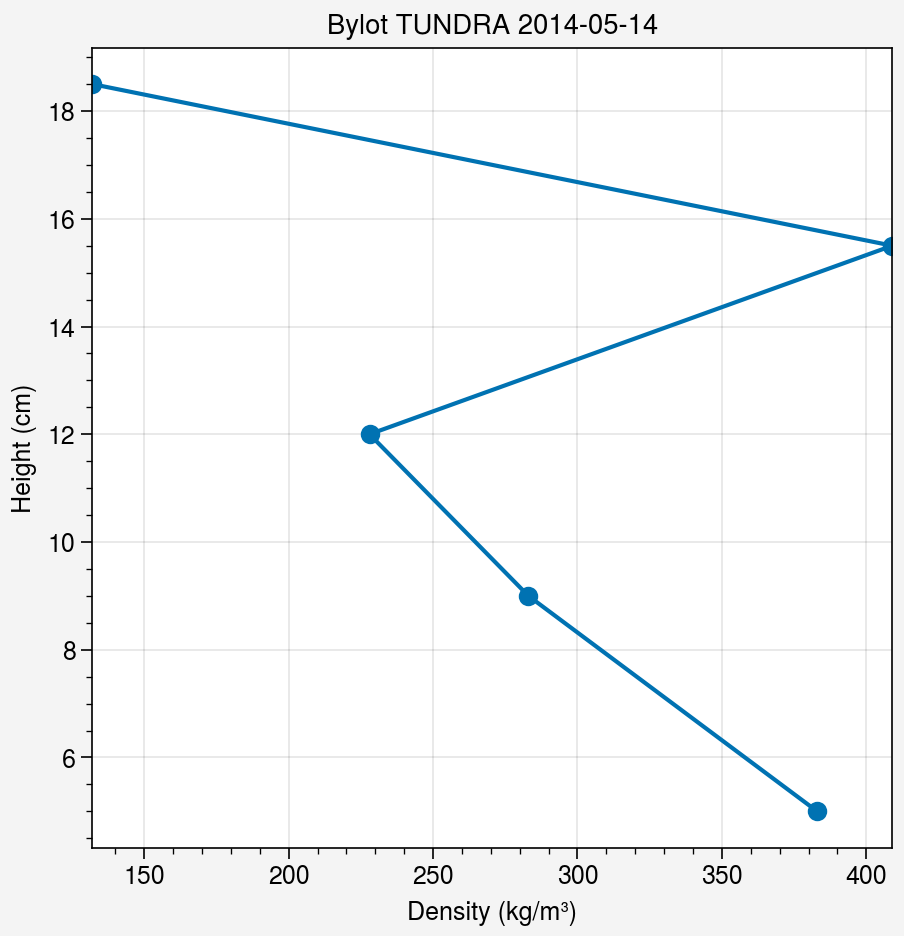

In [192]:
%matplotlib inline
fig, axs = pplt.subplots(refwidth=4)

ax = axs[0]
ax.plot(tundra_df['Density kg m-3'], tundra_df['Height cm'], marker='o', linestyle='-')
ax.format(title='Bylot TUNDRA ' + str(tundra_df.index[0])[:10],
          xlabel='Density (kg/m³)',
          ylabel='Height (cm)',
          grid=True)

In [193]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

df_list_tundra = []
for year in ['2014', '2015', '2017', '2018', '2019']:
# for year in ['2019']:
    df = pd.read_csv(path_obs+'/Bylot/BylotDensity'+year+'.csv', sep=';', parse_dates=['Date'], index_col=['Date'])
    df_list_tundra.append(df[(df['Location'] == 'TUNDRA') | (df['Location'] == 'Tundra')])

/tmp/ipykernel_26560/4090583916.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_obs+'/Bylot/BylotDensity'+year+'.csv', sep=';', parse_dates=['Date'], index_col=['Date'])
/tmp/ipykernel_26560/4090583916.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_obs+'/Bylot/BylotDensity'+year+'.csv', sep=';', parse_dates=['Date'], index_col=['Date'])
/tmp/ipykernel_26560/4090583916.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_obs+'/Bylot/BylotDensity'+year+'.csv', sep=';', parse_dates=['Date'], index_col=['

/home/lalandmi/miniconda3/envs/sc2_v0/lib/python3.10/site-packages/proplot/axes/plot.py:1898: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if autox and autoreverse and x.ndim == 1 and x.size > 1 and x[1] < x[0]:
/home/lalandmi/miniconda3/envs/sc2_v0/lib/python3.10/site-packages/proplot/axes/plot.py:1898: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if autox and autoreverse and x.ndim == 1 and x.size > 1 and x[1] < x[0]:
/home/lalandmi/miniconda3/envs/sc2_v0/lib/python3.10/site-packages/proplot/axes/plot.py:1898: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

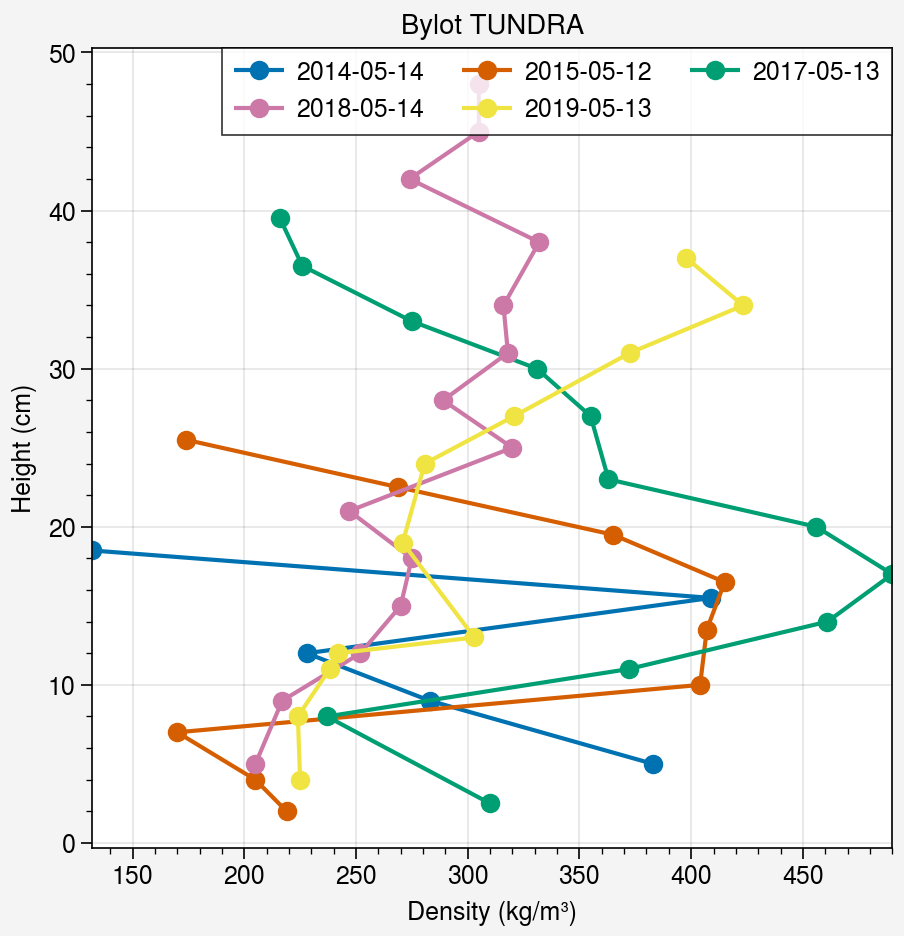

In [194]:
%matplotlib inline
fig, axs = pplt.subplots(refwidth=4)

ax = axs[0]

for tundra_df in df_list_tundra:
    ax.plot(tundra_df['Density kg m-3'], tundra_df['Height cm'], marker='o', linestyle='-', label=str(tundra_df.index[0])[:10])
ax.format(title='Bylot TUNDRA', xlabel='Density (kg/m³)', ylabel='Height (cm)', grid=True)
ax.legend()

In [195]:
df_list_tundra[1]

,Location,Height cm,Density kg m-3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
Date,,,,,,,,,,,,,
2015-05-12,Tundra,25.5,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,22.5,269.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,19.5,365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,16.5,415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,13.5,407.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,10.0,404.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,7.0,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,4.0,205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-12,Tundra,2.0,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
df_list_tundra[1]['Height cm'].iloc[0]-df_list_tundra[1]['Height cm'].iloc[-1]

23.5

In [197]:
for tundra_df in df_list_tundra:
    print(tundra_df.index[0])
    dz = tundra_df['Height cm'].iloc[0]-tundra_df['Height cm'].iloc[-1]
    print('Obs : ' + str(np.trapz(tundra_df['Density kg m-3'], -tundra_df['Height cm'])/dz))
    print('Model : ' + str(ds_d_list[0].snwdens.sel(time=tundra_df.index[0]).values))
    print()

2014-05-14 00:00:00
Obs : 298.1296296296296
Model : 367.19228339186867

2015-05-12 00:00:00
Obs : 310.01063829787233
Model : 224.11801237225595

2017-05-13 00:00:00
Obs : 342.02702702702703
Model : 288.13262434412894

2018-05-14 00:00:00
Obs : 282.1279069767442
Model : 245.52221866439535

2019-05-13 00:00:00
Obs : 300.5924242424242
Model : 408.6525172033164



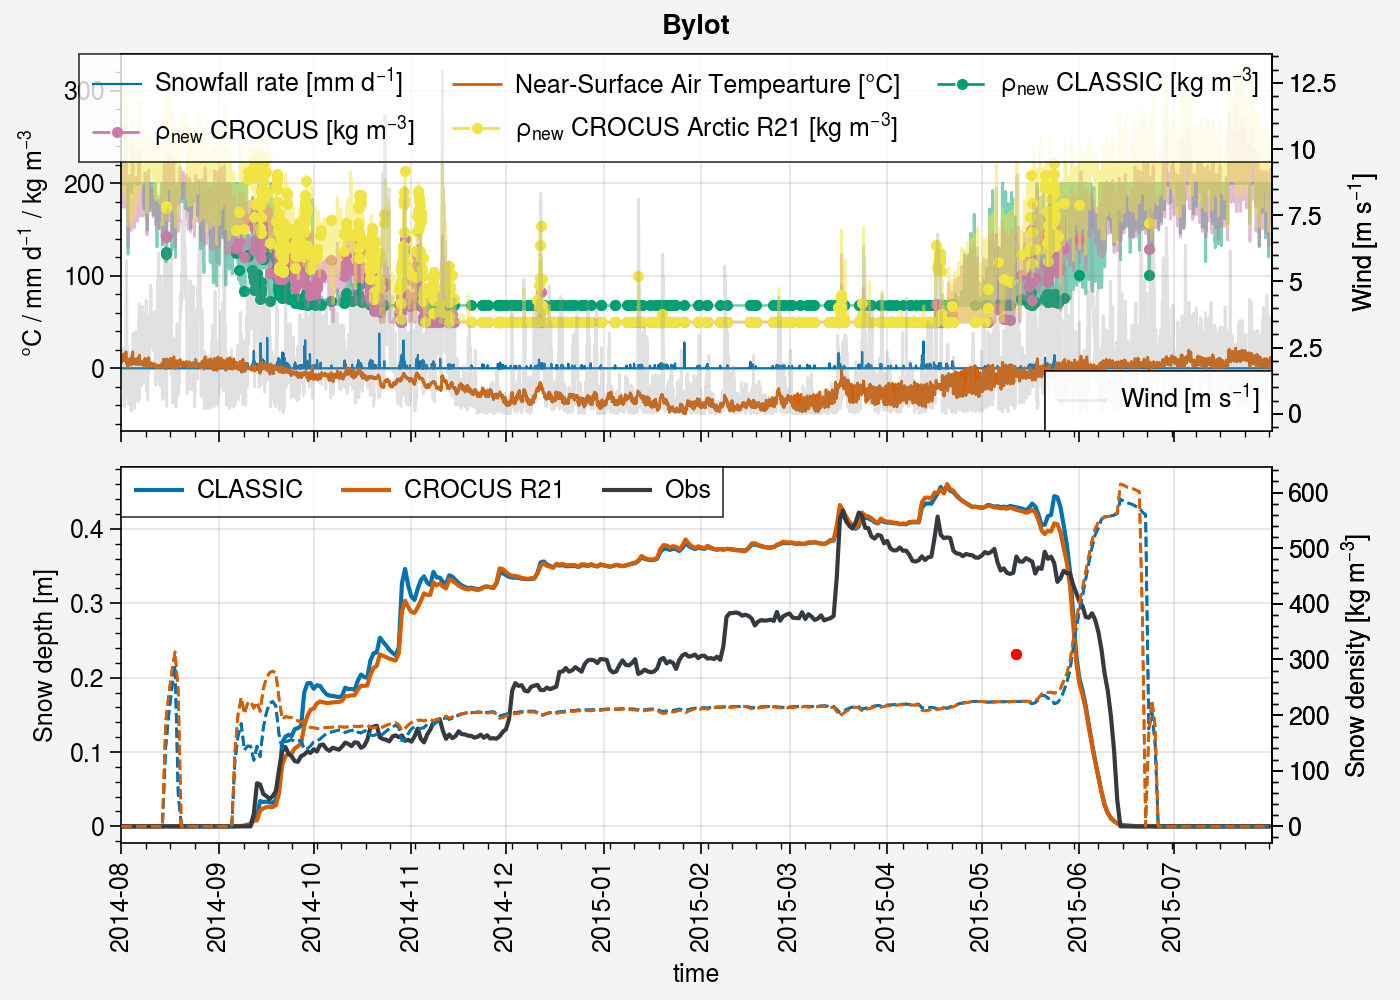

In [230]:
%matplotlib inline

color_obs = 'gray8'

period=slice('2014-08','2015-07')

fig, axs = pplt.subplots(figsize=(7,5), nrows=2, sharey=0)

(ds.sel(time=period).Snowf*86400).plot(label='Snowfall rate [mm d$^{-1}$]', lw=0.8, ax=axs[0])
ds.sel(time=period).Tair.plot(label='Near-Surface Air Tempearture [°C]', lw=1, ax=axs[0])

ox = axs[0].alty(label='Wind [m s$^{-1}$]')
ox.plot(ds.sel(time=period).Wind, label='Wind [m s$^{-1}$]', lw=1, c='gray', alpha=0.15)

# CLASSIC
rho_new_CLASSIC.sel(time=period).plot(c='C2', lw=1, alpha=0.5, ax=axs[0])
rho_new_CLASSIC.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(
    label='$\\rho_{new}$ CLASSIC [kg m$^{-3}$]', c='C2', lw=1, ls='-.', marker='.', ax=axs[0])

# CROCUS
rho_new_CROCUS.sel(time=period).plot(c='C3', lw=1, alpha=0.5, ax=axs[0])
rho_new_CROCUS.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(
    label='$\\rho_{new}$ CROCUS [kg m$^{-3}$]', c='C3', lw=1, ls='-.', marker='.', ax=axs[0])

# CROCUS Arctic R21
rho_new_CROCUS_Arctic_R21.sel(time=period).plot(c='C4', lw=1, alpha=0.5, ax=axs[0])
rho_new_CROCUS_Arctic_R21.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(
    label='$\\rho_{new}$ CROCUS Arctic R21 [kg m$^{-3}$]', c='C4', lw=1, ls='-.', marker='.', ax=axs[0])


axs[0].format(ylabel='°C / mm d$^{-1}$ / kg m$^{-3}$')
axs[0].legend(ncols=3)
ox.legend(ncols=1, loc='lr')


ax = axs[1]
ax.plot(ds_d_list[0].snd.sel(time=period), label='CLASSIC')
ax.plot(ds_d_list[1].snd.sel(time=period), label='CROCUS R21')
# ax.plot(ds_d_list[2].snd.sel(time=period))
ax.plot(ds_d_obs.snd_auto.sel(time=period), c=color_obs, label='Obs')
ax.format(ylabel='Snow depth [m]')

ox = axs[1].alty(label='Snow density [kg m$^{-3}$]')
ox.plot(ds_d_list[0].snwdens.sel(time=period), ls='--', lw=1)
ox.plot(ds_d_list[1].snwdens.sel(time=period), ls='--', lw=1)
# ax.plot(ds_d_list[2].snwdens.sel(time=period))
tundra_df = df_list_tundra[1]
dz = tundra_df['Height cm'].iloc[0]-tundra_df['Height cm'].iloc[-1]
ox.plot(ds_d_obs.sel(time=tundra_df.index[0]).time, 
        np.trapz(tundra_df['Density kg m-3'], -tundra_df['Height cm'])/dz, 
        marker='.', color='red', label='Obs snow density')
# ox.legend(loc='ur')
ax.legend()




fig.suptitle('Bylot')
fig.save('ex_fresh_snow_density_bylot_mtr_v0.jpg')

Text(0.5, 0.98, 'Bylot')

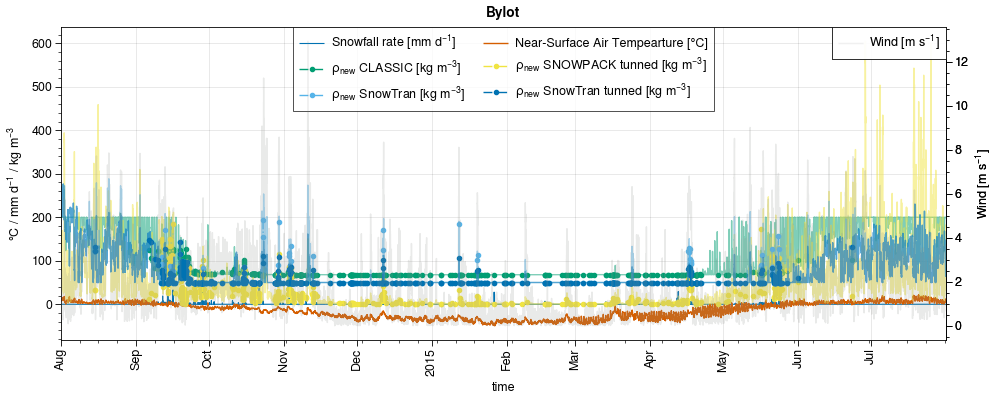

In [152]:
%matplotlib widget

period=slice('2014-08','2015-07')

fig, axs = pplt.subplots(figsize=(10,4))

(ds.sel(time=period).Snowf*86400).plot(label='Snowfall rate [mm d$^{-1}$]', lw=0.8)
ds.sel(time=period).Tair.plot(label='Near-Surface Air Tempearture [°C]', lw=1)

ox = axs[0].alty(label='Wind [m s$^{-1}$]')
ox.plot(ds.sel(time=period).Wind, label='Wind [m s$^{-1}$]', lw=1, c='gray', alpha=0.1)

# CLASSIC
rho_new_CLASSIC.sel(time=period).plot(c='C2', lw=1, alpha=0.5)
rho_new_CLASSIC.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ CLASSIC [kg m$^{-3}$]', 
                                                                           c='C2', lw=1, ls='-.', marker='.')                                                              

# SNOWPACK
# rho_new_SNOWPACK.sel(time=period).plot(c='C3', lw=1, alpha=0.5)
# rho_new_SNOWPACK.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ SNOWPACK [kg m$^{-3}$]', 
#                                                                            c='C3', lw=1, ls='-.', marker='.')

rho_new_SNOWPACK_tunned.sel(time=period).plot(c='C4', lw=1, alpha=0.5)
rho_new_SNOWPACK_tunned.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ SNOWPACK tunned [kg m$^{-3}$]', 
                                                                           c='C4', lw=1, ls='-.', marker='.')

# SnowTran
rho_new_SnowTran.sel(time=period).plot(c='C5', lw=1, alpha=0.5)
rho_new_SnowTran.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ SnowTran [kg m$^{-3}$]', 
                                                                           c='C5', lw=1, ls='-.', marker='.')

rho_new_SnowTran_tunned.sel(time=period).plot(c='C6', lw=1, alpha=0.5)
rho_new_SnowTran_tunned.sel(time=period).where(ds.sel(time=period).Snowf > 0).plot(label='$\\rho_{new}$ SnowTran tunned [kg m$^{-3}$]', 
                                                                           c='C6', lw=1, ls='-.', marker='.')

axs[0].format(ylabel='°C / mm d$^{-1}$ / kg m$^{-3}$')
axs[0].legend(ncols=2)
ox.legend(ncols=2)

fig.suptitle('Bylot')
# fig.save('ex_fresh_snow_density_bylot.jpg')